# ImageNet Baseline - Simple ResNet

This notebook implements a simple baseline on ImageNet using a ResNet architecture.


In [1]:
# Global preparations
import sys
import os
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import RandAugment
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np

sys.path.insert(0, os.path.expanduser('~/spiky'))
device = 'cuda:5'
summation_dtype = torch.float32
random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.enabled = True
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")


PyTorch version: 2.1.2+cu121
Device: cuda:5


## Data Loading

ImageNet dataset loading with standard augmentations for training and validation.


In [2]:
# ImageNet data paths (adjust these to your ImageNet location)
imagenet_train_path = '/path/to/imagenet/train'  # Update this path
imagenet_val_path = '/path/to/imagenet/val'      # Update this path

# Standard ImageNet normalization
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    normalize,
])

# Validation transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

# Note: You need to have ImageNet dataset downloaded
# For demonstration, we'll use ImageNet-like dataset or CIFAR-100 as a proxy
# Uncomment and update paths when you have ImageNet available
"""
train_dataset = torchvision.datasets.ImageFolder(
    root=imagenet_train_path,
    transform=train_transform
)

val_dataset = torchvision.datasets.ImageFolder(
    root=imagenet_val_path,
    transform=val_transform
)
"""

# Using CIFAR-100 as a smaller proxy for testing (same structure as ImageNet)
# Replace with ImageNet when available
print("Using CIFAR-100 as a proxy dataset. Replace with ImageNet for full experiments.")

train_transform_cifar = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])

val_transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])

train_dataset = torchvision.datasets.CIFAR100(
    root='./data',
    train=True,
    download=True,
    transform=train_transform_cifar
)

val_dataset = torchvision.datasets.CIFAR100(
    root='./data',
    train=False,
    download=True,
    transform=val_transform_cifar
)

batch_size = 64
num_workers = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Number of classes: {len(train_dataset.classes)}")


Using CIFAR-100 as a proxy dataset. Replace with ImageNet for full experiments.
Files already downloaded and verified
Files already downloaded and verified
Train dataset size: 50000
Val dataset size: 10000
Number of classes: 100


## Baseline Model

We'll use ResNet18 as a simple baseline. This can be easily replaced with ResNet50 or other architectures.


In [3]:
# Load pre-trained ResNet18 and modify for our dataset
# For CIFAR-100, we'll modify the first conv layer to handle 32x32 images
# For ImageNet (224x224), use standard ResNet18

num_classes = len(train_dataset.classes)

if hasattr(train_dataset, 'classes'):
    # CIFAR-100 or similar small dataset
    model = torchvision.models.resnet18(weights=None)  # Start from scratch
    # Modify first conv layer for smaller input
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()  # Remove maxpool for smaller images
    model.fc = nn.Linear(model.fc.in_features, num_classes)
else:
    # ImageNet
    model = torchvision.models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: ResNet18")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Number of classes: {num_classes}")


Model: ResNet18
Total parameters: 11,220,132
Trainable parameters: 11,220,132
Number of classes: 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


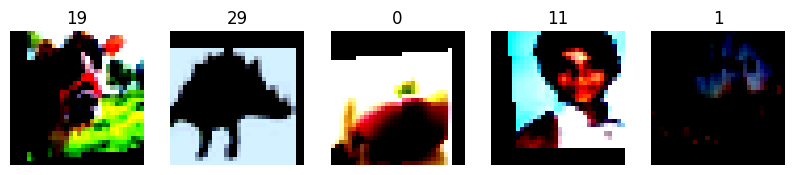

In [4]:
# visualise few samples
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_dataset[i][0].permute(1, 2, 0))
    plt.title(train_dataset[i][1])
    plt.axis('off')

## Training Setup

Define loss function, optimizer, and learning rate scheduler.


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=1e-4
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=30,
    gamma=0.1
)

print("Optimizer: SGD with momentum 0.9, weight decay 1e-4")
print("Initial learning rate: 0.1")
print("Scheduler: StepLR (reduce by 0.1 every 30 epochs)")


Optimizer: SGD with momentum 0.9, weight decay 1e-4
Initial learning rate: 0.1
Scheduler: StepLR (reduce by 0.1 every 30 epochs)


## Training and Evaluation Functions


In [6]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, leave=False)
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        pbar.set_description(f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, leave=False)
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_description(f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


## Training Loop


In [7]:
num_epochs = 100  # Adjust as needed
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print(f"Starting training for {num_epochs} epochs...")
print(f"Batch size: {batch_size}")
print(f"Device: {device}\n")

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Learning rate: {scheduler.get_last_lr()[0]:.6f}')
    
    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update learning rate
    scheduler.step()
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 60)


Starting training for 100 epochs...
Batch size: 64
Device: cuda:5

Epoch 1/100
Learning rate: 0.100000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.2373, Train Acc: 5.70%
Val Loss: 3.7076, Val Acc: 11.38%
------------------------------------------------------------
Epoch 2/100
Learning rate: 0.100000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.6111, Train Acc: 14.50%
Val Loss: 3.0798, Val Acc: 22.95%
------------------------------------------------------------
Epoch 3/100
Learning rate: 0.100000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.0268, Train Acc: 24.35%
Val Loss: 2.7020, Val Acc: 30.96%
------------------------------------------------------------
Epoch 4/100
Learning rate: 0.100000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.5904, Train Acc: 32.90%
Val Loss: 2.4000, Val Acc: 37.01%
------------------------------------------------------------
Epoch 5/100
Learning rate: 0.100000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.2695, Train Acc: 39.72%
Val Loss: 2.0442, Val Acc: 44.83%
------------------------------------------------------------
Epoch 6/100
Learning rate: 0.100000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.0498, Train Acc: 44.66%
Val Loss: 1.8643, Val Acc: 49.46%
------------------------------------------------------------
Epoch 7/100
Learning rate: 0.100000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.8931, Train Acc: 48.69%
Val Loss: 1.7913, Val Acc: 50.93%
------------------------------------------------------------
Epoch 8/100
Learning rate: 0.100000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.7753, Train Acc: 51.14%
Val Loss: 1.6563, Val Acc: 55.33%
------------------------------------------------------------
Epoch 9/100
Learning rate: 0.100000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.6823, Train Acc: 53.54%
Val Loss: 1.6513, Val Acc: 54.10%
------------------------------------------------------------
Epoch 10/100
Learning rate: 0.100000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.6027, Train Acc: 55.35%
Val Loss: 1.7759, Val Acc: 53.54%
------------------------------------------------------------
Epoch 11/100
Learning rate: 0.100000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.5328, Train Acc: 57.01%
Val Loss: 1.4837, Val Acc: 58.61%
------------------------------------------------------------
Epoch 12/100
Learning rate: 0.100000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.4770, Train Acc: 58.44%
Val Loss: 1.4341, Val Acc: 60.00%
------------------------------------------------------------
Epoch 13/100
Learning rate: 0.100000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.4276, Train Acc: 59.93%
Val Loss: 1.4583, Val Acc: 59.92%
------------------------------------------------------------
Epoch 14/100
Learning rate: 0.100000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.3846, Train Acc: 60.78%
Val Loss: 1.3972, Val Acc: 60.89%
------------------------------------------------------------
Epoch 15/100
Learning rate: 0.100000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.3416, Train Acc: 61.65%
Val Loss: 1.4019, Val Acc: 61.61%
------------------------------------------------------------
Epoch 16/100
Learning rate: 0.100000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 1.3002, Train Acc: 62.88%
Val Loss: 1.4576, Val Acc: 61.13%
------------------------------------------------------------
Epoch 17/100
Learning rate: 0.100000


  0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Plot Results


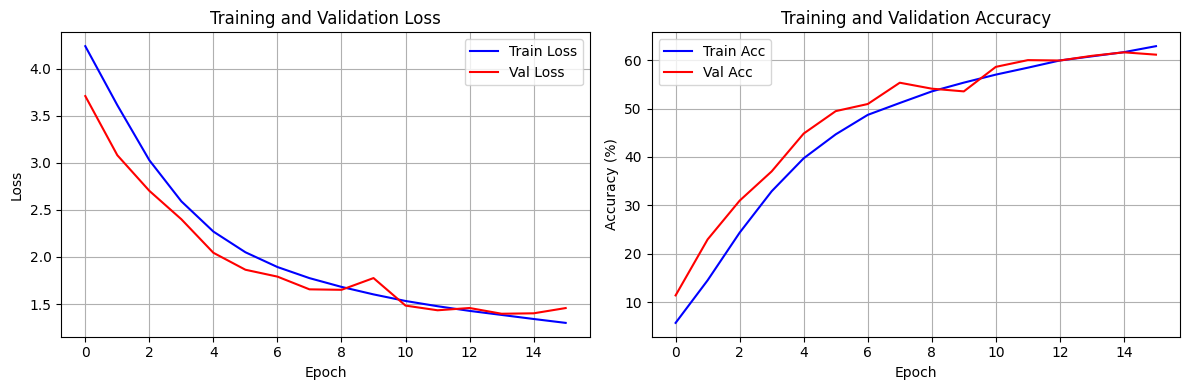

Best validation accuracy: 61.61% at epoch 15


In [8]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Val Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accs, label='Train Acc', color='blue')
ax2.plot(val_accs, label='Val Acc', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Best validation accuracy: {max(val_accs):.2f}% at epoch {val_accs.index(max(val_accs))+1}")


## LUTNet Adaptation to CIFAR-100

Adapting the LUTNet architecture from MNIST to CIFAR-100 classification.


In [12]:
# Import LUTNet components
import sys
import os
sys.path.insert(0, os.path.expanduser('~/spiky'))

from spiky.lut.LUTLayer import (
    Conv2DLUTLayer, LUTSharedContext, SynapseMeta, GradientPolicy, GradientType, LUTLayer
)
from spiky.util.torch_utils import make_lr_getter

# Setup LUTNet shared context and metadata
summation_dtype = torch.float32

synapse_meta = SynapseMeta(
    min_weight=-1.0,
    max_weight=1.0,
    initial_weight=0.01,
    initial_noise_level=-0.02
)

synapse_meta_noisy = SynapseMeta(
    min_weight=-1.0,
    max_weight=1.0,
    initial_weight=1.0,
    initial_noise_level=-1.0
)

shared_lut_ctx = LUTSharedContext()
shared_lut_ctx.to_device(device)
g_policy = GradientPolicy(GradientType.Dense, normalized=False)

print("LUTNet components initialized")


LUTNet components initialized


In [29]:
# LUTNet adapted for CIFAR-100 using Conv2DLUTLayer with BatchNorm and Dropout
class LutNetCIFAR100(nn.Module):
    def __init__(self, device, num_classes=100, dropout_rate=0.0, use_batch_norm=False):
        super().__init__()
        self.use_batch_norm = use_batch_norm
        self.dropout_rate = dropout_rate
        
        # CIFAR-100: 32x32 RGB images (3 channels)
        self.filter_lut_1 = Conv2DLUTLayer(
            input_shape=(32, 32 * 3),  # (32, 96) - concatenate 3 channels along width
            n_anchors_per_detector=8,
            detectors_shape=(6, 6),
            output_kernel_shape=(6, 6),
            receptive_field_shape=(5, 5 * 3),
            receptive_field_stride_shape=(2, 2 * 3),
            lut_receptive_field_shape=(6, 6),
            lut_receptive_field_stride_shape=(6, 6),
            weights_gradient_policy=g_policy,
            do_normalise_weights=True,
            shared_context=shared_lut_ctx,
            synapse_meta=synapse_meta_noisy,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            _forward_group_size=32,
            _backward_group_size=32,
            _max_groups_in_growth_buffer=10**7,
            device=device
        )
        
        self.dropout1 = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()
        
        self.filter_lut_2 = Conv2DLUTLayer(
            input_shape=(84, 84),
            n_anchors_per_detector=8,
            detectors_shape=(6, 6),
            output_kernel_shape=(6, 6),
            receptive_field_shape=(5 * 6, 5 * 6),
            receptive_field_stride_shape=(2 * 6, 2 * 6),
            lut_receptive_field_shape=(6, 6),
            lut_receptive_field_stride_shape=(6, 6),
            weights_gradient_policy=g_policy,
            do_normalise_weights=True,
            shared_context=shared_lut_ctx,
            synapse_meta=synapse_meta_noisy,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            _forward_group_size=32,
            _backward_group_size=32,
            _max_groups_in_growth_buffer=10**7,
            device=device
        )
        
        self.dropout2 = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()
        
        self.filter_lut_3 = Conv2DLUTLayer(
            input_shape=(30, 30),
            n_anchors_per_detector=8,
            detectors_shape=(6, 6),
            output_kernel_shape=(6, 6),
            receptive_field_shape=(5 * 6, 5 * 6),
            receptive_field_stride_shape=(2 * 6, 2 * 6),
            lut_receptive_field_shape=(6, 6),
            lut_receptive_field_stride_shape=(6, 6),
            weights_gradient_policy=g_policy,
            do_normalise_weights=True,
            shared_context=shared_lut_ctx,
            synapse_meta=synapse_meta_noisy,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            _forward_group_size=32,
            _backward_group_size=32,
            _max_groups_in_growth_buffer=10**7,
            device=device
        )
        
        # After filter_lut_3, we reshape to (B, 1, 36), so we use BatchNorm1d
        if use_batch_norm:
            self.bn3 = nn.BatchNorm1d(36, device=device)
        
        self.dropout3 = nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity()
        
        l = []
        bn_list = []
        dropout_list = []
        for i in range(6):
            l.append(
                LUTLayer(
                    n_inputs=36,
                    n_anchors_per_detector=10,
                    n_detectors=32,
                    n_outputs=36,
                    synapse_meta=synapse_meta_noisy,
                    weights_gradient_policy=g_policy,
                    do_normalise_weights=True,
                    shared_context=shared_lut_ctx,
                    summation_dtype=summation_dtype,
                    random_seed=random_seed,
                    device=device
                )
            )
            if use_batch_norm:
                bn_list.append(nn.BatchNorm1d(36, device=device))
            dropout_list.append(nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity())
        
        self.c_luts = nn.ModuleList(l)
        if use_batch_norm:
            self.c_bns = nn.ModuleList(bn_list)
        self.c_dropouts = nn.ModuleList(dropout_list)
        
        # Final layer
        self.final_lut = LUTLayer(
            n_inputs=36,
            n_anchors_per_detector=10,
            n_detectors=32,
            n_outputs=num_classes,
            synapse_meta=synapse_meta_noisy,
            weights_gradient_policy=g_policy,
            do_normalise_weights=True,
            shared_context=shared_lut_ctx,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        
        if use_batch_norm:
            self.final_bn = nn.BatchNorm1d(num_classes, device=device)
        
        self.final_dropout = nn.Dropout(dropout_rate * 0.5) if dropout_rate > 0 else nn.Identity()  # Less dropout on final layer

    def forward(self, x):
        B = x.shape[0]
        # CIFAR-100 input: (B, 3, 32, 32)
        # Reshape to (B, 1, 32, 96) by concatenating channels along width dimension
        if x.shape[1] == 3:
            # Reshape: (B, 3, 32, 32) -> (B, 32, 96) -> (B, 1, 32, 96)
            x = x.permute(0, 2, 1, 3).contiguous()  # (B, 3, 32, 32) -> (B, 32, 3, 32)
            x = x.view(B, 32, 32 * 3)  # (B, 32, 96)
            x = x.unsqueeze(1)  # (B, 1, 32, 96)
        else:
            # Already in correct format
            if len(x.shape) == 3:
                x = x.unsqueeze(1)
        
        # First convolutional LUT layers
        # filter_lut_1 outputs [B, 84, 84] - no channel dimension
        x = F.relu(self.filter_lut_1(x))  # [B, 84, 84]
        x = self.dropout1(x)
        
        # filter_lut_2 outputs [B, 30, 30] - no channel dimension
        x = F.relu(self.filter_lut_2(x))  # [B, 30, 30]
        x = self.dropout2(x)
        
        # filter_lut_3 outputs [B, 6, 6]
        x = F.relu(self.filter_lut_3(x))  # [B, 6, 6]
        
        # Reshape to 1D for subsequent layers: [B, 6, 6] -> [B, 36] -> [B, 1, 36]
        x = x.reshape(B, -1)  # [B, 36]
        x = x.unsqueeze(1)  # [B, 1, 36]
        
        # Now we can apply BatchNorm1d since we have 1D features
        if self.use_batch_norm:
            x = self.bn3(x.squeeze(1)).unsqueeze(1)  # [B, 36] -> [B, 1, 36]
        x = self.dropout3(x)
        
        # Intermediate LUT layers with BatchNorm, Dropout, and skip connections
        for i, (c_lut, dropout) in enumerate(zip(self.c_luts, self.c_dropouts)):
            residual = x
            out = F.relu(c_lut(x))
            if self.use_batch_norm:
                out = self.c_bns[i](out.squeeze(1)).unsqueeze(1)
            out = dropout(out)
            x = residual + out  # Skip connection with normalized output
        
        # Final output layer
        x = F.relu(self.final_lut(x))
        if self.use_batch_norm:
            x = self.final_bn(x.squeeze(1)).unsqueeze(1)
        x = self.final_dropout(x)
        
        # Reshape to (B, num_classes)
        return x.reshape(B, -1)
    
    def setup_external_learning_rate_hook(self, optimizer):
        lr_getter = make_lr_getter(optimizer)
        self.filter_lut_1.set_external_learning_rate_hook(lr_getter)
        self.filter_lut_2.set_external_learning_rate_hook(lr_getter)
        self.filter_lut_3.set_external_learning_rate_hook(lr_getter)
        for c_lut in self.c_luts:
            c_lut.set_external_learning_rate_hook(lr_getter)
        self.final_lut.set_external_learning_rate_hook(lr_getter)

In [30]:
# Create LUTNet model
lut_net = LutNetCIFAR100(device, num_classes=len(train_dataset.classes), dropout_rate=0.0, use_batch_norm=True)
lut_net = lut_net.to(device)

# Count parameters
lut_total_params = sum(p.numel() for p in lut_net.parameters())
lut_trainable_params = sum(p.numel() for p in lut_net.parameters() if p.requires_grad)

print(f"LUTNet Model: {lut_net}")
print(f"Total parameters: {lut_total_params:,}")
print(f"Trainable parameters: {lut_trainable_params:,}")
print(f"Number of classes: {len(train_dataset.classes)}")


LUTNet Model: LutNetCIFAR100(
  (filter_lut_1): Conv2DLUTLayer(input_shape=(32, 96), output_shape=(84, 84), detectors_shape=(6, 6), n_anchors_per_detector=8)
  (dropout1): Identity()
  (filter_lut_2): Conv2DLUTLayer(input_shape=(84, 84), output_shape=(30, 30), detectors_shape=(6, 6), n_anchors_per_detector=8)
  (dropout2): Identity()
  (filter_lut_3): Conv2DLUTLayer(input_shape=(30, 30), output_shape=(6, 6), detectors_shape=(6, 6), n_anchors_per_detector=8)
  (bn3): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Identity()
  (c_luts): ModuleList(
    (0-5): 6 x LUTLayer(36 inputs, 32 detectors, 36 outputs, 10 anchors per detector)
  )
  (c_bns): ModuleList(
    (0-5): 6 x BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (c_dropouts): ModuleList(
    (0-5): 6 x Identity()
  )
  (final_lut): LUTLayer(36 inputs, 32 detectors, 100 outputs, 10 anchors per detector)
  (final_bn): BatchNorm1d(100, eps=1e-05, m

In [31]:
# Setup optimizer and scheduler for LUTNet
from torch.optim.lr_scheduler import LambdaLR

def lr_func(t):
    return min(
        1.0 / (1 + t)**0.5,
        (t / 4000.0) / 4000.0**0.5
    )

# #lr=0.001
# lut_optimizer = torch.optim.SGD(
#     lut_net.parameters(),
#     lr=0.1,
#     momentum=0.9,
#     weight_decay=1e-2
# )
# lut_sched = torch.optim.lr_scheduler.StepLR(
#     lut_optimizer,
#     step_size=30,
#     gamma=0.9
# )
#lut_optimizer = torch.optim.SGD(lut_net.parameters(), lr=0.001)
lr=0.001
lut_optimizer = torch.optim.Adam(lut_net.parameters(), lr=lr)
lut_sched = None
#lut_sched = LambdaLR(lut_optimizer, lr_lambda=lr_func)
#lut_net.setup_external_learning_rate_hook(lut_optimizer)


# lut_optimizer = torch.optim.AdamW(
#     lut_net.parameters(),
#     lr=1e-2,
#     weight_decay=0.001
# )

# lut_sched = torch.optim.lr_scheduler.CosineAnnealingLR(
#     lut_optimizer,
#     T_max=5000
# )

In [5]:
# Training functions for LUTNet
def train_one_epoch_lut(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, leave=False)
    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
#         if scheduler is not None:
#             for _ in range(inputs.shape[0]):
#                 scheduler.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        pbar.set_description(
            f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%, '
            f'lr: {scheduler.get_last_lr()[0] if scheduler is not None else lr:.4f}'
        )
    
    if scheduler is not None:
        scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


def evaluate_lut(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, leave=False)
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_description(f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


## LUTNet Training Loop


In [6]:
# LUTNet training
lut_criterion = nn.CrossEntropyLoss()
# def loss_func(o, t):
#     return F.cross_entropy(
#         o, t,
#         reduction='none'
#     ).sum()
# lut_criterion = loss_func
lut_train_losses = []
lut_train_accs = []
lut_val_losses = []
lut_val_accs = []

In [34]:
lut_num_epochs = 1000  # Adjust as needed

print(f"Starting LUTNet training for {lut_num_epochs} epochs...")
print(f"Batch size: {batch_size}")
print(f"Device: {device}\n")

for epoch in range(lut_num_epochs):
    print(f'LUTNet Epoch {epoch+1}/{lut_num_epochs}')
    print(f'Learning rate: {lut_sched.get_last_lr()[0] if lut_sched is not None else lr:.6f}')
    
    # Train
    train_loss, train_acc = train_one_epoch_lut(
        lut_net, train_loader, lut_criterion, lut_optimizer, lut_sched, device
    )
    lut_train_losses.append(train_loss)
    lut_train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = evaluate_lut(lut_net, val_loader, lut_criterion, device)
    lut_val_losses.append(val_loss)
    lut_val_accs.append(val_acc)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 60)


Starting LUTNet training for 1000 epochs...
Batch size: 64
Device: cuda:5

LUTNet Epoch 1/1000
Learning rate: 0.001000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.9095, Train Acc: 0.98%
Val Loss: 4.7807, Val Acc: 0.89%
------------------------------------------------------------
LUTNet Epoch 2/1000
Learning rate: 0.001000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.7147, Train Acc: 1.03%
Val Loss: 4.6670, Val Acc: 1.00%
------------------------------------------------------------
LUTNet Epoch 3/1000
Learning rate: 0.001000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.6416, Train Acc: 0.99%
Val Loss: 4.6246, Val Acc: 1.10%
------------------------------------------------------------
LUTNet Epoch 4/1000
Learning rate: 0.001000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.6173, Train Acc: 1.03%
Val Loss: 4.6103, Val Acc: 0.93%
------------------------------------------------------------
LUTNet Epoch 5/1000
Learning rate: 0.001000


  0%|          | 0/782 [00:00<?, ?it/s]

Exception in thread Thread-74:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/flynn/vr_venv/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 54, in _pin_memory_loop
    do_one_step()
  File "/home/flynn/vr_venv/lib/python3.8/site-packages/torch/utils/data/_utils/pin_memory.py", line 31, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/home/flynn/vr_venv/lib/python3.8/site-packages/torch/multiprocessing/reductions.py", line 355, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.8/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3

KeyboardInterrupt: 

## Plot LUTNet Results


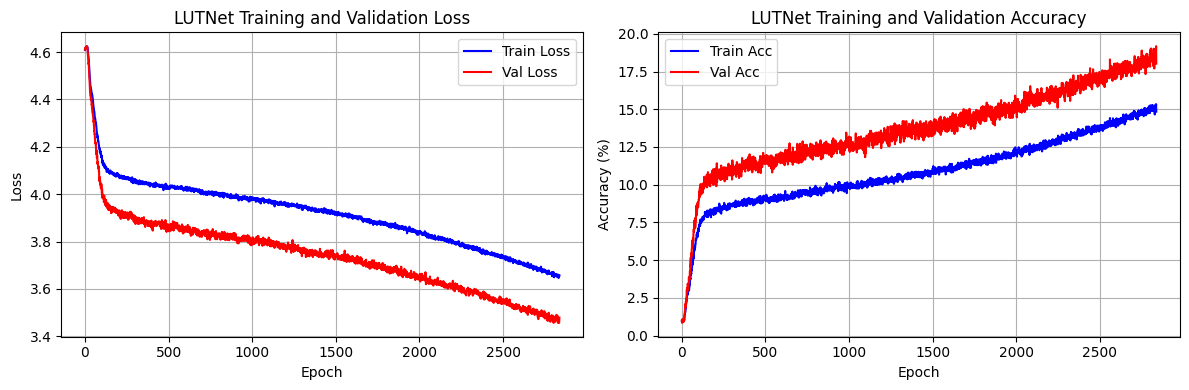

LUTNet Best validation accuracy: 19.18% at epoch 2837


In [364]:
# Plot LUTNet training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(lut_train_losses, label='Train Loss', color='blue')
ax1.plot(lut_val_losses, label='Val Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('LUTNet Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(lut_train_accs, label='Train Acc', color='blue')
ax2.plot(lut_val_accs, label='Val Acc', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('LUTNet Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

if len(lut_val_accs) > 0:
    print(f"LUTNet Best validation accuracy: {max(lut_val_accs):.2f}% at epoch {lut_val_accs.index(max(lut_val_accs))+1}")


In [161]:
filter_lut = Conv2DLUTLayer(
            input_shape=(30, 30),
            n_anchors_per_detector=8,
            detectors_shape=(6, 6),
            output_kernel_shape=(6, 6),
            receptive_field_shape=(5 * 6, 5 * 6),
            receptive_field_stride_shape=(2 * 6, 2 * 6),
            lut_receptive_field_shape=(6, 6),
            lut_receptive_field_stride_shape=(6, 6),
            weights_gradient_policy=g_policy,
            shared_context=shared_lut_ctx,
            synapse_meta=synapse_meta,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            _forward_group_size=32,
            _backward_group_size=32,
            _max_groups_in_growth_buffer=10**7,
            device=device
        )

In [162]:
filter_lut._output_shape

(6, 6)

In [44]:
filter_lut

Conv2DLUTLayer(input_shape=(56, 56), output_shape=(20, 20), detectors_shape=(4, 4), n_anchors_per_detector=8)

In [57]:
76 / 4

19.0

In [41]:
56 / 4

14.0

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualWrap(nn.Module):
    def __init__(self, block: nn.Module, activation: str = "relu"):
        super().__init__()
        self.block = block
        self.activation = activation

    def forward(self, x):
        y = self.block(x)
        if self.activation == "relu":
            y = F.relu(y)
        elif self.activation is None:
            pass
        else:
            raise ValueError(f"Unknown activation: {self.activation}")
        return x + y  # assumes same shape

class BiasAdd(nn.Module):
    def __init__(self, shape, device=None, dtype=None):
        """
        shape: bias shape excluding batch, e.g.
          - (C,) for vectors
          - (C, H, W) for NCHW tensors
          - (D,) for last-dim features
        """
        super().__init__()
        self.bias = nn.Parameter(torch.ones(*shape, device=device, dtype=dtype))

    def forward(self, x):
        return x + self.bias  # broadcasts over batch automatically

class Reshape(nn.Module):
    def __init__(self, shape):  # shape excludes batch
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.view(x.size(0), *self.shape)

class AlexNetCIFAR100(nn.Module):
    """
    AlexNet-inspired backbone adapted to 32x32 CIFAR.
    Keeps the "big conv stack + 2x4096 FC" spirit, but uses smaller kernels/strides.
    """
    def __init__(self, num_classes: int = 100, dropout: float = 0.5):
        super().__init__()

        self.features = nn.Sequential(
            # 32x32
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16

            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8

            nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),  # 4x4
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            LUTLayer(
                n_inputs=4096,
                n_anchors_per_detector=8,
                n_detectors=1024,
                n_outputs=64,
                synapse_meta=synapse_meta_1,
                weights_gradient_policy=g_policy,
                do_normalise_weights=True,
                shared_context=shared_lut_ctx,
                summation_dtype=summation_dtype,
                random_seed=random_seed,
                device=device
            ),
            # BiasAdd((1, 128,)),
            # nn.Linear(4096, 64),
            # nn.ReLU(inplace=False),
#             Reshape((64,)),
#             nn.BatchNorm1d(64),
#             Reshape((1, 64)),
            nn.Dropout(dropout),
#             ResidualWrap(
                nn.Sequential(
                    LUTLayer(
                        n_inputs=64,
                        n_anchors_per_detector=8,
                        n_detectors=64,
                        n_outputs=64,
                        synapse_meta=synapse_meta_1,
                        weights_gradient_policy=g_policy,
                        do_normalise_weights=True,
                        shared_context=shared_lut_ctx,
                        summation_dtype=summation_dtype,
                        random_seed=random_seed,
                        device=device
                    ),
                    # BiasAdd((1, 128,))
                ),
#                 nn.Sequential(
#                     nn.Linear(64, 64),
#                 ),
#                 activation=None # "relu",
#             ),
#             Reshape((64,)),
#             nn.BatchNorm1d(64),
#             Reshape((1, 64)),
            # BiasAdd((256,)),
            # nn.Linear(4096, 4096),
            # nn.ReLU(inplace=False),
#             nn.Dropout(dropout),
# #             ResidualWrap(
#                  nn.Sequential(
#                     LUTLayer(
#                         n_inputs=64,
#                         n_anchors_per_detector=8,
#                         n_detectors=64,
#                         n_outputs=64,
#                         synapse_meta=synapse_meta_1,
#                         weights_gradient_policy=g_policy,
#                         do_normalise_weights=True,
#                         shared_context=shared_lut_ctx,
#                         summation_dtype=summation_dtype,
#                         random_seed=random_seed,
#                         device=device
#                     ),
#                     # BiasAdd((1, 64,))
#                 ),
#                 nn.Sequential(
#                     nn.Linear(64, 64),
#                 ),
#                 activation=None # "relu",
#             ),
#             Reshape((64,)),
#             nn.BatchNorm1d(64),
#             Reshape((1, 64)),
#             nn.Dropout(dropout),
#             ResidualWrap(
                nn.Sequential(
                    LUTLayer(
                        n_inputs=64,
                        n_anchors_per_detector=8,
                        n_detectors=64,
                        n_outputs=64,
                        synapse_meta=synapse_meta_1,
                        weights_gradient_policy=g_policy,
                        do_normalise_weights=True,
                        shared_context=shared_lut_ctx,
                        summation_dtype=summation_dtype,
                        random_seed=random_seed,
                        device=device
                    ),
                    # BiasAdd((1, 64,))
                ),
#                 nn.Sequential(
#                     nn.Linear(64, 64),
#                 ),
#                 activation=None # "relu",
#             ),
#             Reshape((64,)),
#             nn.BatchNorm1d(64),
#             Reshape((1, 64)),
            # BiasAdd((256,)),
            # nn.Linear(4096, 4096),
            # nn.ReLU(inplace=False),
        )
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1).unsqueeze(1)  # (B, 256*4*4)
        x = self.classifier(x)
        x = self.fc(torch.flatten(x, 1))
        return x


In [42]:
from spiky.lut.ANDNLUTLayer import ANDNLUTLayerEx
from spiky.lut.LUTLayer import GradientPolicy, GradientType, LUTSharedContext, LUTLayerBasic, LUTLayer
from spiky.util.synapse_growth import PointSamplingPolicy, PointSamplingType
from spiky.andn.ANDNLayer import SynapseMeta

input_shape=(32, 32 * 3)
final_output_shape = (1, 100)
synapse_meta_1 = SynapseMeta(
    min_weight=0.0,
    max_weight=5.0,
    initial_weight=5.0,
    initial_noise_level=-5.0
)

# synapse_meta_1 = SynapseMeta(
#     min_weight=0.0,
#     max_weight=1.0,
#     initial_weight=0.0,
#     initial_noise_level=0.0
# )

# synapse_meta_2 = SynapseMeta(
#     min_weight=-1.0,
#     max_weight=1.0,
#     initial_weight=0.0,
#     initial_noise_level=0.0
# )

shared_lut_ctx = LUTSharedContext()
shared_lut_ctx.to_device(device)
g_policy = GradientPolicy(GradientType.Dense, normalized=False)


class LUTANDNNet(nn.Module):
    def __init__(self, device):
        super().__init__()
        #sp_mask_1 = uniform_sparsity_mask(input_shape[0] * 2, input_shape[1] * 2, 0.2, device)
        sp_mask_1 = None
        self.layer1 = ANDNLUTLayerEx(
            input_shape=input_shape,
            output_shape=(input_shape[0] * 2, input_shape[1] * 2),
            n_anchors_per_detector=3,
            n_detector_groups=256,
            n_detectors_in_group=4,
            receptive_shape=(5, 5),
            projection_shape=(10, 10),
            detectors_sampling_policy=PointSamplingPolicy(
                PointSamplingType.Grid, grid_h=16, grid_w=16
            ),
            output_sparsity_mask=sp_mask_1,
            inhibition_window_shape=(3, 3),
            n_inhibitors=4096,
            n_neurons_per_inhibitor=9,
            dropout=0.0,
            synapse_meta=synapse_meta_1,
            do_normalize_weights=True,
            backprop_hebb_ratio_on_torch_backward=0.0,
            anti_hebb_coeff=0.0,
            relu_before_inhibition=True,
            residual=False,
            weights_gradient_policy=g_policy,
            shared_context=shared_lut_ctx,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        
        #sp_mask_10 = uniform_sparsity_mask(input_shape[0] * 4, input_shape[1] * 4, 0.2, device)
        sp_mask_10 = None
        self.layer10 = ANDNLUTLayerEx(
            input_shape=(input_shape[0] * 2, input_shape[1] * 2),
            output_shape=(input_shape[0] * 4, input_shape[1] * 4),
            n_anchors_per_detector=4,
            n_detector_groups=144,
            n_detectors_in_group=8,
            receptive_shape=(10, 10),
            projection_shape=(20, 20),
            detectors_sampling_policy=PointSamplingPolicy(
                PointSamplingType.Grid, grid_h=12, grid_w=12
            ),
            input_sparsity_mask=sp_mask_1,
            output_sparsity_mask=sp_mask_10,
            inhibition_window_shape=(3, 3),
            n_inhibitors=8192,
            n_neurons_per_inhibitor=9,
            dropout=0.0,
            synapse_meta=synapse_meta_1,
            do_normalize_weights=True,
            backprop_hebb_ratio_on_torch_backward=0.0,
            anti_hebb_coeff=0.0,
            relu_before_inhibition=True,
            residual=False,
            weights_gradient_policy=g_policy,
            shared_context=shared_lut_ctx,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        
        #sp_mask_11 = uniform_sparsity_mask(input_shape[0] * 2, input_shape[1] * 2, 0.2, device)
        sp_mask_11 = None
        self.layer11 = ANDNLUTLayerEx(
            input_shape=(input_shape[0] * 4, input_shape[1] * 4),
            output_shape=(input_shape[0] * 2, input_shape[1] * 2),
            n_anchors_per_detector=4,
            n_detector_groups=64,
            n_detectors_in_group=16,
            receptive_shape=(20, 20),
            projection_shape=(10, 10),
            detectors_sampling_policy=PointSamplingPolicy(
                PointSamplingType.Grid, grid_h=8, grid_w=8
            ),
            input_sparsity_mask=sp_mask_10,
            output_sparsity_mask=sp_mask_11,
            inhibition_window_shape=(3, 3),
            n_inhibitors=4096,
            n_neurons_per_inhibitor=9,
            dropout=0.0,
            synapse_meta=synapse_meta_1,
            do_normalize_weights=True,
            backprop_hebb_ratio_on_torch_backward=0.0,
            anti_hebb_coeff=0.0,
            relu_before_inhibition=True,
            residual=False,
            weights_gradient_policy=g_policy,
            shared_context=shared_lut_ctx,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        
        #sp_mask_2 = uniform_sparsity_mask(input_shape[0], input_shape[1], 0.2, device)
        sp_mask_2 = None
        self.layer2 = ANDNLUTLayerEx(
            input_shape=(input_shape[0] * 2, input_shape[1] * 2),
            output_shape=(input_shape[0], input_shape[1]),
            n_anchors_per_detector=5,
            n_detector_groups=64,
            n_detectors_in_group=16,
            receptive_shape=(20, 20),
            projection_shape=(5, 5),
            input_sparsity_mask=sp_mask_1,
            output_sparsity_mask=sp_mask_2,
            detectors_sampling_policy=PointSamplingPolicy(
                PointSamplingType.Grid, grid_h=8, grid_w=8
            ),
            inhibition_window_shape=(3, 3),
            n_inhibitors=2048,
            n_neurons_per_inhibitor=9,
            dropout=0.0,
            synapse_meta=synapse_meta_1,
            do_normalize_weights=True,
            backprop_hebb_ratio_on_torch_backward=0.0,
            anti_hebb_coeff=0.0,
            relu_before_inhibition=True,
            residual=False,
            weights_gradient_policy=g_policy,
            shared_context=shared_lut_ctx,
            summation_dtype=summation_dtype,
            random_seed=random_seed + 1,
            device=device
        )
        
        self.layer3 = LUTLayer(
            n_inputs=input_shape[0]*input_shape[1],
            n_anchors_per_detector=8,
            n_detectors=256,
            n_outputs=input_shape[0]*input_shape[1],
            synapse_meta=synapse_meta_1,
            weights_gradient_policy=g_policy,
            do_normalise_weights=True,
            shared_context=shared_lut_ctx,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        
        self.layer4 = LUTLayer(
            n_inputs=input_shape[0]*input_shape[1],
            n_anchors_per_detector=8,
            n_detectors=256,
            n_outputs=input_shape[0]*input_shape[1],
            synapse_meta=synapse_meta_1,
            weights_gradient_policy=g_policy,
            do_normalise_weights=True,
            shared_context=shared_lut_ctx,
            summation_dtype=summation_dtype,
            random_seed=random_seed,
            device=device
        )
        
#         self.layer5 = LUTLayer(
#             n_inputs=input_shape[0]*input_shape[1],
#             n_anchors_per_detector=8,
#             n_detectors=256,
#             n_outputs=input_shape[0]*input_shape[1],
#             synapse_meta=synapse_meta_1,
#             weights_gradient_policy=g_policy,
#             do_normalise_weights=True,
#             shared_context=shared_lut_ctx,
#             summation_dtype=summation_dtype,
#             random_seed=random_seed,
#             device=device
#         )
        
#         self.layer6 = LUTLayer(
#             n_inputs=input_shape[0]*input_shape[1],
#             n_anchors_per_detector=8,
#             n_detectors=256,
#             n_outputs=input_shape[0]*input_shape[1],
#             synapse_meta=synapse_meta_1,
#             weights_gradient_policy=g_policy,
#             do_normalise_weights=True,
#             shared_context=shared_lut_ctx,
#             summation_dtype=summation_dtype,
#             random_seed=random_seed,
#             device=device
#         )

#         self.layer2 = LUTLayer(
#             n_inputs=input_shape[0] * 2 * input_shape[1] * 2,
#             n_outputs=64,
#             n_detectors=256,
#             n_anchors_per_detector=8,
#             sequence_length=1,
#             weights_gradient_policy=g_policy,
#             shared_context=shared_lut_ctx,
#             summation_dtype=summation_dtype,
#             device=device,
#             random_seed=random_seed,
#         )

        osh = self.layer2._andn_layer.output_shape()
        #osh = (8, 8)
        self.final_layer = nn.Linear(osh[0] * osh[1], final_output_shape[1], device=device)
        self._l1_res = None
        self._l2_res = None
        # self.final_layer = nn.Linear(28 * 28, final_output_shape[1], device=device)
        
        osh1 = self.layer1._andn_layer.output_shape()  # (H1, W1)
        osh10 = self.layer10._andn_layer.output_shape()  # (H1, W1)
        osh11 = self.layer11._andn_layer.output_shape()  # (H1, W1)
        osh2 = self.layer2._andn_layer.output_shape()  # (H2, W2) == input_shape
        self.bn1 = nn.BatchNorm1d(osh1[0] * osh1[1], device=device)
        self.bn10 = nn.BatchNorm1d(osh10[0] * osh10[1], device=device)
        self.bn11 = nn.BatchNorm1d(osh11[0] * osh11[1], device=device)
        self.bn2 = nn.BatchNorm1d(osh2[0] * osh2[1], device=device)
        self.bn3 = nn.BatchNorm1d(input_shape[0] * input_shape[1], device=device)
        self.bn4 = nn.BatchNorm1d(input_shape[0] * input_shape[1], device=device)
#         self.bn5 = nn.BatchNorm1d(input_shape[0] * input_shape[1], device=device)
#         self.bn6 = nn.BatchNorm1d(input_shape[0] * input_shape[1], device=device)


    def forward(self, x):
        B = x.shape[0]

        if x.shape[1] == 3:
            x = x.permute(0, 2, 1, 3).contiguous()
            x = x.view(B, 32, 32 * 3).unsqueeze(1)
        else:
            if len(x.shape) == 3:
                x = x.unsqueeze(1)

        # layer1 -> BN
        l1 = self.layer1(x)  # (B, H1, W1) or similar
        l1f = l1.reshape(B, -1)
        l1f = self.bn1(l1f)
        l1f = l1f.view_as(l1)
        
        l10 = self.layer10(l1f.unsqueeze(1))  # (B, H1, W1) or similar
        l10f = l10.reshape(B, -1)
        l10f = self.bn10(l10f)
        l10f = l10f.view_as(l10)
        
        l11 = self.layer11(l10f.unsqueeze(1))  # (B, H1, W1) or similar
        l11f = l11.reshape(B, -1)
        self._l1_res = self.bn11(l11f).view_as(l11)

        # layer2 -> BN
        l2 = self.layer2(self._l1_res.unsqueeze(1))
        l2f = l2.reshape(B, -1)
        l2f = self.bn2(l2f)
        self._l2_res = l2f.view_as(l2)

        # layer3 -> BN -> ReLU -> residual add
        x3 = self._l2_res.reshape(B, 1, -1)
        y3 = F.relu(self.layer3(x3))                      # (B, 1, D)
        l3_res = self.bn3((x3 + y3).squeeze(1)).unsqueeze(1)   # BN on (B, D)

        # layer4 -> BN -> ReLU -> residual add
        y4 = F.relu(self.layer4(l3_res))                    # (B, 1, D)
        l4_res = self.bn4((l3_res + y4).squeeze(1)).unsqueeze(1)
        
#         # layer4 -> BN -> ReLU -> residual add
#         y5 = F.relu(self.layer5(l4_res))                 # (B, 1, D)
#         l5_res = self.bn5((l4_res + y5).squeeze(1)).unsqueeze(1)
        
#         # layer4 -> BN -> ReLU -> residual add
#         y6 = F.relu(self.layer6(l5_res))                  # (B, 1, D)
#         l6_res = self.bn6((l5_res + y6).squeeze(1)).unsqueeze(1)

        return self.final_layer(l4_res.view(B, -1))


In [43]:
lut_andn_net = AlexNetCIFAR100(dropout=0.0)
lut_andn_net.to(device)

# Count parameters
lut_total_params = sum(p.numel() for p in lut_andn_net.parameters())
lut_trainable_params = sum(p.numel() for p in lut_andn_net.parameters() if p.requires_grad)

print(f"LUTNet Model: {lut_andn_net}")
print(f"Total parameters: {lut_total_params:,}")
print(f"Trainable parameters: {lut_trainable_params:,}")

LUTNet Model: AlexNetCIFAR100(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tra

In [44]:
# Setup optimizer and scheduler for LUTNet
from torch.optim.lr_scheduler import LambdaLR

def lr_func(t):
    return min(
        1.0 / (1 + t)**0.5,
        (t / 4000.0) / 4000.0**0.5
    )

# #lr=0.001
# lut_optimizer = torch.optim.SGD(
#     lut_net.parameters(),
#     lr=0.1,
#     momentum=0.9,
#     weight_decay=1e-2
# )
# lut_sched = torch.optim.lr_scheduler.StepLR(
#     lut_optimizer,
#     step_size=30,
#     gamma=0.9
# )
#lut_optimizer = torch.optim.SGD(lut_net.parameters(), lr=0.001)
lr=0.001
lut_optimizer = torch.optim.Adam(lut_andn_net.parameters(), lr=lr)
#lut_sched = None
#lut_sched = LambdaLR(lut_optimizer, lr_lambda=lr_func)
#lut_net.setup_external_learning_rate_hook(lut_optimizer)


# lut_optimizer = torch.optim.AdamW(
#     lut_net.parameters(),
#     lr=1e-2,
#     weight_decay=0.001
# )

lut_sched = torch.optim.lr_scheduler.CosineAnnealingLR(
    lut_optimizer,
    T_max=200
)

In [45]:
# LUTNet training
lut_criterion = nn.CrossEntropyLoss()
# def loss_func(o, t):
#     return F.cross_entropy(
#         o, t,
#         reduction='none'
#     ).sum()
# lut_criterion = loss_func
lut_train_losses = []
lut_train_accs = []
lut_val_losses = []
lut_val_accs = []

In [46]:
lut_num_epochs = 200  # Adjust as needed

print(f"Starting LUTNet training for {lut_num_epochs} epochs...")
print(f"Batch size: {batch_size}")
print(f"Device: {device}\n")

for epoch in range(lut_num_epochs):
    print(f'LUTNet Epoch {epoch+1}/{lut_num_epochs}')
    print(f'Learning rate: {lut_sched.get_last_lr()[0] if lut_sched is not None else lr:.6f}')
    
    # Train
    train_loss, train_acc = train_one_epoch_lut(
        lut_andn_net, train_loader, lut_criterion, lut_optimizer, lut_sched, device
    )
    lut_train_losses.append(train_loss)
    lut_train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = evaluate_lut(lut_andn_net, val_loader, lut_criterion, device)
    lut_val_losses.append(val_loss)
    lut_val_accs.append(val_acc)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 60)


Starting LUTNet training for 200 epochs...
Batch size: 64
Device: cuda:5

LUTNet Epoch 1/200
Learning rate: 0.001000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.8285, Train Acc: 1.01%
Val Loss: 4.7662, Val Acc: 1.00%
------------------------------------------------------------
LUTNet Epoch 2/200
Learning rate: 0.001000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.7559, Train Acc: 1.11%
Val Loss: 4.6948, Val Acc: 1.88%
------------------------------------------------------------
LUTNet Epoch 3/200
Learning rate: 0.001000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.6642, Train Acc: 1.94%
Val Loss: 4.5306, Val Acc: 3.12%
------------------------------------------------------------
LUTNet Epoch 4/200
Learning rate: 0.000999


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.5651, Train Acc: 2.57%
Val Loss: 4.3710, Val Acc: 3.25%
------------------------------------------------------------
LUTNet Epoch 5/200
Learning rate: 0.000999


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.5015, Train Acc: 2.91%
Val Loss: 4.3039, Val Acc: 3.76%
------------------------------------------------------------
LUTNet Epoch 6/200
Learning rate: 0.000998


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.4514, Train Acc: 3.16%
Val Loss: 4.3041, Val Acc: 3.91%
------------------------------------------------------------
LUTNet Epoch 7/200
Learning rate: 0.000998


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.3766, Train Acc: 3.58%
Val Loss: 4.1845, Val Acc: 5.35%
------------------------------------------------------------
LUTNet Epoch 8/200
Learning rate: 0.000997


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.3045, Train Acc: 4.25%
Val Loss: 4.0974, Val Acc: 6.04%
------------------------------------------------------------
LUTNet Epoch 9/200
Learning rate: 0.000996


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.2788, Train Acc: 4.65%
Val Loss: 4.0716, Val Acc: 6.65%
------------------------------------------------------------
LUTNet Epoch 10/200
Learning rate: 0.000995


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.2362, Train Acc: 5.07%
Val Loss: 4.0960, Val Acc: 6.50%
------------------------------------------------------------
LUTNet Epoch 11/200
Learning rate: 0.000994


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.1919, Train Acc: 5.62%
Val Loss: 3.9473, Val Acc: 8.20%
------------------------------------------------------------
LUTNet Epoch 12/200
Learning rate: 0.000993


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.1517, Train Acc: 6.19%
Val Loss: 3.9344, Val Acc: 8.56%
------------------------------------------------------------
LUTNet Epoch 13/200
Learning rate: 0.000991


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.1292, Train Acc: 6.60%
Val Loss: 3.8685, Val Acc: 9.36%
------------------------------------------------------------
LUTNet Epoch 14/200
Learning rate: 0.000990


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.0826, Train Acc: 7.29%
Val Loss: 3.8330, Val Acc: 10.17%
------------------------------------------------------------
LUTNet Epoch 15/200
Learning rate: 0.000988


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.0734, Train Acc: 7.60%
Val Loss: 3.8366, Val Acc: 10.10%
------------------------------------------------------------
LUTNet Epoch 16/200
Learning rate: 0.000986


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.0437, Train Acc: 7.88%
Val Loss: 3.8951, Val Acc: 9.87%
------------------------------------------------------------
LUTNet Epoch 17/200
Learning rate: 0.000984


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.0379, Train Acc: 7.77%
Val Loss: 3.8031, Val Acc: 10.59%
------------------------------------------------------------
LUTNet Epoch 18/200
Learning rate: 0.000982


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 4.0119, Train Acc: 8.39%
Val Loss: 3.7811, Val Acc: 11.23%
------------------------------------------------------------
LUTNet Epoch 19/200
Learning rate: 0.000980


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.9829, Train Acc: 8.71%
Val Loss: 3.7704, Val Acc: 11.49%
------------------------------------------------------------
LUTNet Epoch 20/200
Learning rate: 0.000978


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.9769, Train Acc: 8.91%
Val Loss: 3.7399, Val Acc: 12.03%
------------------------------------------------------------
LUTNet Epoch 21/200
Learning rate: 0.000976


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.9380, Train Acc: 9.52%
Val Loss: 3.7019, Val Acc: 12.53%
------------------------------------------------------------
LUTNet Epoch 22/200
Learning rate: 0.000973


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.9314, Train Acc: 9.43%
Val Loss: 3.6735, Val Acc: 13.59%
------------------------------------------------------------
LUTNet Epoch 23/200
Learning rate: 0.000970


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.9033, Train Acc: 9.92%
Val Loss: 3.6608, Val Acc: 13.40%
------------------------------------------------------------
LUTNet Epoch 24/200
Learning rate: 0.000968


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.8819, Train Acc: 10.26%
Val Loss: 3.6334, Val Acc: 13.61%
------------------------------------------------------------
LUTNet Epoch 25/200
Learning rate: 0.000965


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.8688, Train Acc: 10.61%
Val Loss: 3.6713, Val Acc: 13.24%
------------------------------------------------------------
LUTNet Epoch 26/200
Learning rate: 0.000962


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.8537, Train Acc: 10.81%
Val Loss: 3.5910, Val Acc: 14.56%
------------------------------------------------------------
LUTNet Epoch 27/200
Learning rate: 0.000959


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.8279, Train Acc: 11.30%
Val Loss: 3.6289, Val Acc: 14.01%
------------------------------------------------------------
LUTNet Epoch 28/200
Learning rate: 0.000956


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.8177, Train Acc: 11.40%
Val Loss: 3.5524, Val Acc: 14.98%
------------------------------------------------------------
LUTNet Epoch 29/200
Learning rate: 0.000952


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.8045, Train Acc: 11.64%
Val Loss: 3.5462, Val Acc: 15.92%
------------------------------------------------------------
LUTNet Epoch 30/200
Learning rate: 0.000949


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.7750, Train Acc: 12.12%
Val Loss: 3.5296, Val Acc: 15.47%
------------------------------------------------------------
LUTNet Epoch 31/200
Learning rate: 0.000946


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.7682, Train Acc: 12.29%
Val Loss: 3.5287, Val Acc: 16.06%
------------------------------------------------------------
LUTNet Epoch 32/200
Learning rate: 0.000942


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.7486, Train Acc: 12.49%
Val Loss: 3.5055, Val Acc: 16.32%
------------------------------------------------------------
LUTNet Epoch 33/200
Learning rate: 0.000938


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.7296, Train Acc: 12.82%
Val Loss: 3.4912, Val Acc: 16.61%
------------------------------------------------------------
LUTNet Epoch 34/200
Learning rate: 0.000934


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.7228, Train Acc: 12.99%
Val Loss: 3.4633, Val Acc: 17.25%
------------------------------------------------------------
LUTNet Epoch 35/200
Learning rate: 0.000930


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.7198, Train Acc: 12.86%
Val Loss: 3.4917, Val Acc: 16.35%
------------------------------------------------------------
LUTNet Epoch 36/200
Learning rate: 0.000926


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.7055, Train Acc: 13.29%
Val Loss: 3.4464, Val Acc: 17.28%
------------------------------------------------------------
LUTNet Epoch 37/200
Learning rate: 0.000922


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.6916, Train Acc: 13.63%
Val Loss: 3.3942, Val Acc: 17.90%
------------------------------------------------------------
LUTNet Epoch 38/200
Learning rate: 0.000918


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.6720, Train Acc: 13.74%
Val Loss: 3.3862, Val Acc: 18.16%
------------------------------------------------------------
LUTNet Epoch 39/200
Learning rate: 0.000914


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.6722, Train Acc: 13.86%
Val Loss: 3.4593, Val Acc: 17.19%
------------------------------------------------------------
LUTNet Epoch 40/200
Learning rate: 0.000909


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.6696, Train Acc: 14.23%
Val Loss: 3.4300, Val Acc: 17.79%
------------------------------------------------------------
LUTNet Epoch 41/200
Learning rate: 0.000905


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.6701, Train Acc: 13.99%
Val Loss: 3.4090, Val Acc: 18.22%
------------------------------------------------------------
LUTNet Epoch 42/200
Learning rate: 0.000900


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.6481, Train Acc: 14.19%
Val Loss: 3.4232, Val Acc: 17.74%
------------------------------------------------------------
LUTNet Epoch 43/200
Learning rate: 0.000895


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.6434, Train Acc: 14.11%
Val Loss: 3.3705, Val Acc: 18.95%
------------------------------------------------------------
LUTNet Epoch 44/200
Learning rate: 0.000890


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.6200, Train Acc: 14.69%
Val Loss: 3.3292, Val Acc: 19.36%
------------------------------------------------------------
LUTNet Epoch 45/200
Learning rate: 0.000885


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.6010, Train Acc: 14.99%
Val Loss: 3.3223, Val Acc: 19.43%
------------------------------------------------------------
LUTNet Epoch 46/200
Learning rate: 0.000880


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.6066, Train Acc: 15.02%
Val Loss: 3.3496, Val Acc: 18.85%
------------------------------------------------------------
LUTNet Epoch 47/200
Learning rate: 0.000875


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.5929, Train Acc: 15.13%
Val Loss: 3.3196, Val Acc: 19.42%
------------------------------------------------------------
LUTNet Epoch 48/200
Learning rate: 0.000870


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.5949, Train Acc: 14.93%
Val Loss: 3.3225, Val Acc: 19.71%
------------------------------------------------------------
LUTNet Epoch 49/200
Learning rate: 0.000864


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.5741, Train Acc: 15.63%
Val Loss: 3.3346, Val Acc: 19.47%
------------------------------------------------------------
LUTNet Epoch 50/200
Learning rate: 0.000859


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.5827, Train Acc: 15.33%
Val Loss: 3.3437, Val Acc: 19.18%
------------------------------------------------------------
LUTNet Epoch 51/200
Learning rate: 0.000854


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.5930, Train Acc: 15.05%
Val Loss: 3.3449, Val Acc: 18.94%
------------------------------------------------------------
LUTNet Epoch 52/200
Learning rate: 0.000848


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.5784, Train Acc: 15.29%
Val Loss: 3.3004, Val Acc: 20.03%
------------------------------------------------------------
LUTNet Epoch 53/200
Learning rate: 0.000842


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.5505, Train Acc: 15.91%
Val Loss: 3.2658, Val Acc: 20.18%
------------------------------------------------------------
LUTNet Epoch 54/200
Learning rate: 0.000837


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.5488, Train Acc: 15.78%
Val Loss: 3.2821, Val Acc: 20.36%
------------------------------------------------------------
LUTNet Epoch 55/200
Learning rate: 0.000831


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.5494, Train Acc: 15.78%
Val Loss: 3.2464, Val Acc: 20.99%
------------------------------------------------------------
LUTNet Epoch 56/200
Learning rate: 0.000825


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.5340, Train Acc: 16.20%
Val Loss: 3.2611, Val Acc: 20.60%
------------------------------------------------------------
LUTNet Epoch 57/200
Learning rate: 0.000819


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.5165, Train Acc: 16.48%
Val Loss: 3.2470, Val Acc: 21.23%
------------------------------------------------------------
LUTNet Epoch 58/200
Learning rate: 0.000813


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.5131, Train Acc: 16.34%
Val Loss: 3.2597, Val Acc: 20.72%
------------------------------------------------------------
LUTNet Epoch 59/200
Learning rate: 0.000806


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.5015, Train Acc: 16.74%
Val Loss: 3.2620, Val Acc: 21.08%
------------------------------------------------------------
LUTNet Epoch 60/200
Learning rate: 0.000800


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.4907, Train Acc: 16.87%
Val Loss: 3.2222, Val Acc: 21.75%
------------------------------------------------------------
LUTNet Epoch 61/200
Learning rate: 0.000794


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.4856, Train Acc: 17.07%
Val Loss: 3.2640, Val Acc: 20.91%
------------------------------------------------------------
LUTNet Epoch 62/200
Learning rate: 0.000788


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.4732, Train Acc: 17.21%
Val Loss: 3.2168, Val Acc: 21.79%
------------------------------------------------------------
LUTNet Epoch 63/200
Learning rate: 0.000781


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.4766, Train Acc: 17.27%
Val Loss: 3.1991, Val Acc: 22.19%
------------------------------------------------------------
LUTNet Epoch 64/200
Learning rate: 0.000775


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.4541, Train Acc: 17.40%
Val Loss: 3.2254, Val Acc: 21.62%
------------------------------------------------------------
LUTNet Epoch 65/200
Learning rate: 0.000768


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.4492, Train Acc: 17.52%
Val Loss: 3.1987, Val Acc: 22.42%
------------------------------------------------------------
LUTNet Epoch 66/200
Learning rate: 0.000761


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.4531, Train Acc: 17.79%
Val Loss: 3.2212, Val Acc: 22.14%
------------------------------------------------------------
LUTNet Epoch 67/200
Learning rate: 0.000755


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.4472, Train Acc: 17.80%
Val Loss: 3.2102, Val Acc: 21.89%
------------------------------------------------------------
LUTNet Epoch 68/200
Learning rate: 0.000748


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.4368, Train Acc: 17.81%
Val Loss: 3.2025, Val Acc: 22.24%
------------------------------------------------------------
LUTNet Epoch 69/200
Learning rate: 0.000741


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.4153, Train Acc: 18.35%
Val Loss: 3.1687, Val Acc: 22.87%
------------------------------------------------------------
LUTNet Epoch 70/200
Learning rate: 0.000734


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.4206, Train Acc: 18.08%
Val Loss: 3.1526, Val Acc: 23.19%
------------------------------------------------------------
LUTNet Epoch 71/200
Learning rate: 0.000727


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.3926, Train Acc: 18.58%
Val Loss: 3.1577, Val Acc: 22.94%
------------------------------------------------------------
LUTNet Epoch 72/200
Learning rate: 0.000720


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.3864, Train Acc: 18.72%
Val Loss: 3.1454, Val Acc: 22.76%
------------------------------------------------------------
LUTNet Epoch 73/200
Learning rate: 0.000713


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.3932, Train Acc: 18.42%
Val Loss: 3.1826, Val Acc: 22.41%
------------------------------------------------------------
LUTNet Epoch 74/200
Learning rate: 0.000706


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.3920, Train Acc: 18.63%
Val Loss: 3.1418, Val Acc: 23.10%
------------------------------------------------------------
LUTNet Epoch 75/200
Learning rate: 0.000699


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.3943, Train Acc: 18.63%
Val Loss: 3.1693, Val Acc: 22.61%
------------------------------------------------------------
LUTNet Epoch 76/200
Learning rate: 0.000691


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.3768, Train Acc: 18.80%
Val Loss: 3.1325, Val Acc: 24.05%
------------------------------------------------------------
LUTNet Epoch 77/200
Learning rate: 0.000684


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.3484, Train Acc: 19.39%
Val Loss: 3.1481, Val Acc: 23.52%
------------------------------------------------------------
LUTNet Epoch 78/200
Learning rate: 0.000677


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.3592, Train Acc: 19.19%
Val Loss: 3.1361, Val Acc: 22.96%
------------------------------------------------------------
LUTNet Epoch 79/200
Learning rate: 0.000669


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.3484, Train Acc: 19.19%
Val Loss: 3.0983, Val Acc: 23.54%
------------------------------------------------------------
LUTNet Epoch 80/200
Learning rate: 0.000662


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.3351, Train Acc: 19.39%
Val Loss: 3.0979, Val Acc: 24.01%
------------------------------------------------------------
LUTNet Epoch 81/200
Learning rate: 0.000655


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.3248, Train Acc: 19.73%
Val Loss: 3.0772, Val Acc: 24.06%
------------------------------------------------------------
LUTNet Epoch 82/200
Learning rate: 0.000647


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.3373, Train Acc: 19.51%
Val Loss: 3.0927, Val Acc: 24.03%
------------------------------------------------------------
LUTNet Epoch 83/200
Learning rate: 0.000639


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.3301, Train Acc: 19.67%
Val Loss: 3.1263, Val Acc: 23.23%
------------------------------------------------------------
LUTNet Epoch 84/200
Learning rate: 0.000632


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.3494, Train Acc: 19.43%
Val Loss: 3.0898, Val Acc: 24.26%
------------------------------------------------------------
LUTNet Epoch 85/200
Learning rate: 0.000624


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.3236, Train Acc: 20.10%
Val Loss: 3.0946, Val Acc: 23.93%
------------------------------------------------------------
LUTNet Epoch 86/200
Learning rate: 0.000617


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.3083, Train Acc: 19.82%
Val Loss: 3.0999, Val Acc: 24.46%
------------------------------------------------------------
LUTNet Epoch 87/200
Learning rate: 0.000609


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.2894, Train Acc: 20.29%
Val Loss: 3.0617, Val Acc: 25.00%
------------------------------------------------------------
LUTNet Epoch 88/200
Learning rate: 0.000601


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.2988, Train Acc: 19.95%
Val Loss: 3.0715, Val Acc: 24.61%
------------------------------------------------------------
LUTNet Epoch 89/200
Learning rate: 0.000594


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.2932, Train Acc: 20.44%
Val Loss: 3.0674, Val Acc: 24.97%
------------------------------------------------------------
LUTNet Epoch 90/200
Learning rate: 0.000586


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.2976, Train Acc: 20.43%
Val Loss: 3.1076, Val Acc: 24.20%
------------------------------------------------------------
LUTNet Epoch 91/200
Learning rate: 0.000578


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.2740, Train Acc: 20.77%
Val Loss: 3.0941, Val Acc: 24.48%
------------------------------------------------------------
LUTNet Epoch 92/200
Learning rate: 0.000570


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.2830, Train Acc: 20.27%
Val Loss: 3.1156, Val Acc: 23.72%
------------------------------------------------------------
LUTNet Epoch 93/200
Learning rate: 0.000563


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.2678, Train Acc: 20.73%
Val Loss: 3.0559, Val Acc: 24.86%
------------------------------------------------------------
LUTNet Epoch 94/200
Learning rate: 0.000555


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.2686, Train Acc: 20.77%
Val Loss: 3.0593, Val Acc: 25.21%
------------------------------------------------------------
LUTNet Epoch 95/200
Learning rate: 0.000547


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.2482, Train Acc: 20.90%
Val Loss: 3.0348, Val Acc: 25.05%
------------------------------------------------------------
LUTNet Epoch 96/200
Learning rate: 0.000539


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.2410, Train Acc: 21.55%
Val Loss: 3.0423, Val Acc: 25.20%
------------------------------------------------------------
LUTNet Epoch 97/200
Learning rate: 0.000531


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.2306, Train Acc: 21.41%
Val Loss: 3.0532, Val Acc: 24.18%
------------------------------------------------------------
LUTNet Epoch 98/200
Learning rate: 0.000524


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.2249, Train Acc: 21.42%
Val Loss: 3.0360, Val Acc: 25.00%
------------------------------------------------------------
LUTNet Epoch 99/200
Learning rate: 0.000516


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.2182, Train Acc: 21.78%
Val Loss: 3.0075, Val Acc: 25.88%
------------------------------------------------------------
LUTNet Epoch 100/200
Learning rate: 0.000508


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.2295, Train Acc: 21.31%
Val Loss: 3.0303, Val Acc: 25.46%
------------------------------------------------------------
LUTNet Epoch 101/200
Learning rate: 0.000500


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.2036, Train Acc: 21.65%
Val Loss: 3.0064, Val Acc: 26.09%
------------------------------------------------------------
LUTNet Epoch 102/200
Learning rate: 0.000492


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.2132, Train Acc: 21.75%
Val Loss: 3.0222, Val Acc: 25.28%
------------------------------------------------------------
LUTNet Epoch 103/200
Learning rate: 0.000484


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.1977, Train Acc: 22.19%
Val Loss: 3.0085, Val Acc: 25.93%
------------------------------------------------------------
LUTNet Epoch 104/200
Learning rate: 0.000476


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.1875, Train Acc: 22.10%
Val Loss: 3.0003, Val Acc: 25.88%
------------------------------------------------------------
LUTNet Epoch 105/200
Learning rate: 0.000469


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.1900, Train Acc: 22.18%
Val Loss: 3.0345, Val Acc: 25.76%
------------------------------------------------------------
LUTNet Epoch 106/200
Learning rate: 0.000461


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.2069, Train Acc: 21.84%
Val Loss: 3.0123, Val Acc: 25.24%
------------------------------------------------------------
LUTNet Epoch 107/200
Learning rate: 0.000453


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.1727, Train Acc: 22.48%
Val Loss: 2.9817, Val Acc: 26.62%
------------------------------------------------------------
LUTNet Epoch 108/200
Learning rate: 0.000445


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.1695, Train Acc: 22.57%
Val Loss: 3.0015, Val Acc: 26.14%
------------------------------------------------------------
LUTNet Epoch 109/200
Learning rate: 0.000437


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.1647, Train Acc: 22.78%
Val Loss: 3.0016, Val Acc: 26.04%
------------------------------------------------------------
LUTNet Epoch 110/200
Learning rate: 0.000430


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.1706, Train Acc: 22.37%
Val Loss: 2.9816, Val Acc: 26.41%
------------------------------------------------------------
LUTNet Epoch 111/200
Learning rate: 0.000422


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.1467, Train Acc: 22.93%
Val Loss: 2.9544, Val Acc: 27.19%
------------------------------------------------------------
LUTNet Epoch 112/200
Learning rate: 0.000414


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.1665, Train Acc: 22.74%
Val Loss: 2.9631, Val Acc: 27.02%
------------------------------------------------------------
LUTNet Epoch 113/200
Learning rate: 0.000406


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.1486, Train Acc: 23.20%
Val Loss: 3.0023, Val Acc: 25.76%
------------------------------------------------------------
LUTNet Epoch 114/200
Learning rate: 0.000399


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.1232, Train Acc: 23.47%
Val Loss: 2.9896, Val Acc: 26.41%
------------------------------------------------------------
LUTNet Epoch 115/200
Learning rate: 0.000391


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.1267, Train Acc: 23.24%
Val Loss: 2.9660, Val Acc: 26.66%
------------------------------------------------------------
LUTNet Epoch 116/200
Learning rate: 0.000383


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.1214, Train Acc: 23.60%
Val Loss: 2.9441, Val Acc: 26.83%
------------------------------------------------------------
LUTNet Epoch 117/200
Learning rate: 0.000376


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.0969, Train Acc: 23.67%
Val Loss: 2.9612, Val Acc: 27.19%
------------------------------------------------------------
LUTNet Epoch 118/200
Learning rate: 0.000368


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.1150, Train Acc: 23.52%
Val Loss: 2.9395, Val Acc: 27.54%
------------------------------------------------------------
LUTNet Epoch 119/200
Learning rate: 0.000361


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.1043, Train Acc: 23.79%
Val Loss: 2.9308, Val Acc: 27.38%
------------------------------------------------------------
LUTNet Epoch 120/200
Learning rate: 0.000353


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.0938, Train Acc: 23.97%
Val Loss: 2.9508, Val Acc: 27.49%
------------------------------------------------------------
LUTNet Epoch 121/200
Learning rate: 0.000345


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.0930, Train Acc: 23.76%
Val Loss: 2.9464, Val Acc: 27.00%
------------------------------------------------------------
LUTNet Epoch 122/200
Learning rate: 0.000338


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.0173, Train Acc: 25.21%
Val Loss: 2.8884, Val Acc: 28.49%
------------------------------------------------------------
LUTNet Epoch 134/200
Learning rate: 0.000252


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 3.0123, Train Acc: 25.39%
Val Loss: 2.9022, Val Acc: 28.02%
------------------------------------------------------------
LUTNet Epoch 135/200
Learning rate: 0.000245


  0%|          | 0/782 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.9802, Train Acc: 26.01%
Val Loss: 2.8860, Val Acc: 28.63%
------------------------------------------------------------
LUTNet Epoch 143/200
Learning rate: 0.000194


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.9795, Train Acc: 26.02%
Val Loss: 2.8756, Val Acc: 28.62%
------------------------------------------------------------
LUTNet Epoch 144/200
Learning rate: 0.000187


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.9497, Train Acc: 26.62%
Val Loss: 2.8656, Val Acc: 28.78%
------------------------------------------------------------
LUTNet Epoch 152/200
Learning rate: 0.000141


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.9203, Train Acc: 27.22%
Val Loss: 2.8428, Val Acc: 29.41%
------------------------------------------------------------
LUTNet Epoch 154/200
Learning rate: 0.000130


  0%|          | 0/782 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.9274, Train Acc: 27.09%
Val Loss: 2.8462, Val Acc: 29.32%
------------------------------------------------------------
LUTNet Epoch 156/200
Learning rate: 0.000120


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.9286, Train Acc: 26.80%
Val Loss: 2.8471, Val Acc: 29.13%
------------------------------------------------------------
LUTNet Epoch 157/200
Learning rate: 0.000115


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.9295, Train Acc: 26.87%
Val Loss: 2.8416, Val Acc: 29.73%
------------------------------------------------------------
LUTNet Epoch 158/200
Learning rate: 0.000110


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.9214, Train Acc: 27.08%
Val Loss: 2.8359, Val Acc: 29.08%
------------------------------------------------------------
LUTNet Epoch 159/200
Learning rate: 0.000105


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.9144, Train Acc: 27.03%
Val Loss: 2.8406, Val Acc: 29.04%
------------------------------------------------------------
LUTNet Epoch 160/200
Learning rate: 0.000100


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.9062, Train Acc: 27.50%
Val Loss: 2.8493, Val Acc: 29.29%
------------------------------------------------------------
LUTNet Epoch 161/200
Learning rate: 0.000095


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.9056, Train Acc: 27.34%
Val Loss: 2.8492, Val Acc: 29.32%
------------------------------------------------------------
LUTNet Epoch 162/200
Learning rate: 0.000091


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8959, Train Acc: 27.69%
Val Loss: 2.8236, Val Acc: 29.92%
------------------------------------------------------------
LUTNet Epoch 163/200
Learning rate: 0.000086


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.9078, Train Acc: 27.29%
Val Loss: 2.8483, Val Acc: 29.21%
------------------------------------------------------------
LUTNet Epoch 164/200
Learning rate: 0.000082


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8982, Train Acc: 27.33%
Val Loss: 2.8338, Val Acc: 29.62%
------------------------------------------------------------
LUTNet Epoch 165/200
Learning rate: 0.000078


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8967, Train Acc: 27.59%
Val Loss: 2.8413, Val Acc: 29.94%
------------------------------------------------------------
LUTNet Epoch 166/200
Learning rate: 0.000074


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8952, Train Acc: 27.53%
Val Loss: 2.8440, Val Acc: 29.39%
------------------------------------------------------------
LUTNet Epoch 167/200
Learning rate: 0.000070


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8942, Train Acc: 27.76%
Val Loss: 2.8342, Val Acc: 29.55%
------------------------------------------------------------
LUTNet Epoch 168/200
Learning rate: 0.000066


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8902, Train Acc: 27.69%
Val Loss: 2.8343, Val Acc: 29.71%
------------------------------------------------------------
LUTNet Epoch 169/200
Learning rate: 0.000062


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8868, Train Acc: 27.99%
Val Loss: 2.8324, Val Acc: 29.43%
------------------------------------------------------------
LUTNet Epoch 170/200
Learning rate: 0.000058


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8907, Train Acc: 27.64%
Val Loss: 2.8366, Val Acc: 29.25%
------------------------------------------------------------
LUTNet Epoch 172/200
Learning rate: 0.000051


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8845, Train Acc: 27.72%
Val Loss: 2.8224, Val Acc: 29.72%
------------------------------------------------------------
LUTNet Epoch 173/200
Learning rate: 0.000048


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8760, Train Acc: 28.01%
Val Loss: 2.8266, Val Acc: 29.47%
------------------------------------------------------------
LUTNet Epoch 174/200
Learning rate: 0.000044


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8785, Train Acc: 27.86%
Val Loss: 2.8318, Val Acc: 29.59%
------------------------------------------------------------
LUTNet Epoch 175/200
Learning rate: 0.000041


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8782, Train Acc: 27.69%
Val Loss: 2.8150, Val Acc: 30.10%
------------------------------------------------------------
LUTNet Epoch 176/200
Learning rate: 0.000038


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8783, Train Acc: 27.81%
Val Loss: 2.8241, Val Acc: 29.71%
------------------------------------------------------------
LUTNet Epoch 177/200
Learning rate: 0.000035


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8749, Train Acc: 28.10%
Val Loss: 2.8199, Val Acc: 30.26%
------------------------------------------------------------
LUTNet Epoch 178/200
Learning rate: 0.000032


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8730, Train Acc: 27.96%
Val Loss: 2.8112, Val Acc: 29.80%
------------------------------------------------------------
LUTNet Epoch 179/200
Learning rate: 0.000030


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8741, Train Acc: 27.88%
Val Loss: 2.8232, Val Acc: 29.80%
------------------------------------------------------------
LUTNet Epoch 180/200
Learning rate: 0.000027


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8703, Train Acc: 28.03%
Val Loss: 2.8200, Val Acc: 30.34%
------------------------------------------------------------
LUTNet Epoch 181/200
Learning rate: 0.000024


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8778, Train Acc: 27.71%
Val Loss: 2.8185, Val Acc: 30.18%
------------------------------------------------------------
LUTNet Epoch 182/200
Learning rate: 0.000022


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8639, Train Acc: 28.16%
Val Loss: 2.8215, Val Acc: 29.66%
------------------------------------------------------------
LUTNet Epoch 183/200
Learning rate: 0.000020


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8645, Train Acc: 28.30%
Val Loss: 2.8222, Val Acc: 29.68%
------------------------------------------------------------
LUTNet Epoch 184/200
Learning rate: 0.000018


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8573, Train Acc: 28.45%
Val Loss: 2.8305, Val Acc: 29.82%
------------------------------------------------------------
LUTNet Epoch 185/200
Learning rate: 0.000016


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8666, Train Acc: 27.89%
Val Loss: 2.8263, Val Acc: 29.76%
------------------------------------------------------------
LUTNet Epoch 186/200
Learning rate: 0.000014


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8662, Train Acc: 28.34%
Val Loss: 2.8143, Val Acc: 29.97%
------------------------------------------------------------
LUTNet Epoch 187/200
Learning rate: 0.000012


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8644, Train Acc: 28.42%
Val Loss: 2.8202, Val Acc: 29.78%
------------------------------------------------------------
LUTNet Epoch 188/200
Learning rate: 0.000010


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8643, Train Acc: 28.21%
Val Loss: 2.8200, Val Acc: 30.15%
------------------------------------------------------------
LUTNet Epoch 189/200
Learning rate: 0.000009


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8646, Train Acc: 28.04%
Val Loss: 2.8321, Val Acc: 29.56%
------------------------------------------------------------
LUTNet Epoch 190/200
Learning rate: 0.000007


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8539, Train Acc: 28.58%
Val Loss: 2.8201, Val Acc: 29.79%
------------------------------------------------------------
LUTNet Epoch 191/200
Learning rate: 0.000006


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8580, Train Acc: 28.35%
Val Loss: 2.8296, Val Acc: 29.78%
------------------------------------------------------------
LUTNet Epoch 192/200
Learning rate: 0.000005


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8572, Train Acc: 28.32%
Val Loss: 2.8181, Val Acc: 30.16%
------------------------------------------------------------
LUTNet Epoch 193/200
Learning rate: 0.000004


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8606, Train Acc: 28.26%
Val Loss: 2.8169, Val Acc: 30.06%
------------------------------------------------------------
LUTNet Epoch 194/200
Learning rate: 0.000003


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8600, Train Acc: 28.29%
Val Loss: 2.8186, Val Acc: 29.80%
------------------------------------------------------------
LUTNet Epoch 195/200
Learning rate: 0.000002


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8635, Train Acc: 28.29%
Val Loss: 2.8278, Val Acc: 29.74%
------------------------------------------------------------
LUTNet Epoch 196/200
Learning rate: 0.000002


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8554, Train Acc: 28.33%
Val Loss: 2.8145, Val Acc: 30.13%
------------------------------------------------------------
LUTNet Epoch 197/200
Learning rate: 0.000001


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8568, Train Acc: 28.44%
Val Loss: 2.8237, Val Acc: 29.64%
------------------------------------------------------------
LUTNet Epoch 198/200
Learning rate: 0.000001


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8584, Train Acc: 28.24%
Val Loss: 2.8242, Val Acc: 30.01%
------------------------------------------------------------
LUTNet Epoch 199/200
Learning rate: 0.000000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8507, Train Acc: 28.60%
Val Loss: 2.8116, Val Acc: 29.77%
------------------------------------------------------------
LUTNet Epoch 200/200
Learning rate: 0.000000


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Train Loss: 2.8710, Train Acc: 28.19%
Val Loss: 2.8202, Val Acc: 29.95%
------------------------------------------------------------


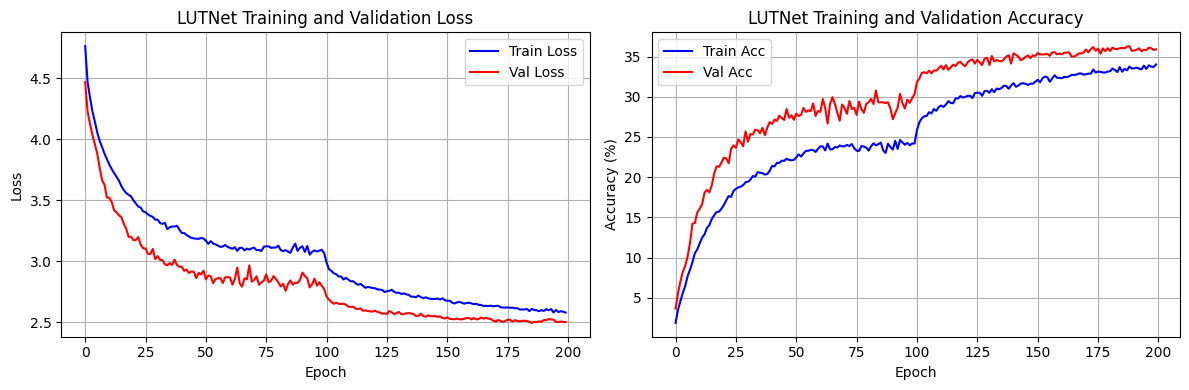

LUTNet Best validation accuracy: 36.30% at epoch 189


In [35]:
# Plot LUTNet training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(lut_train_losses, label='Train Loss', color='blue')
ax1.plot(lut_val_losses, label='Val Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('LUTNet Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(lut_train_accs, label='Train Acc', color='blue')
ax2.plot(lut_val_accs, label='Val Acc', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('LUTNet Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

if len(lut_val_accs) > 0:
    print(f"LUTNet Best validation accuracy: {max(lut_val_accs):.2f}% at epoch {lut_val_accs.index(max(lut_val_accs))+1}")


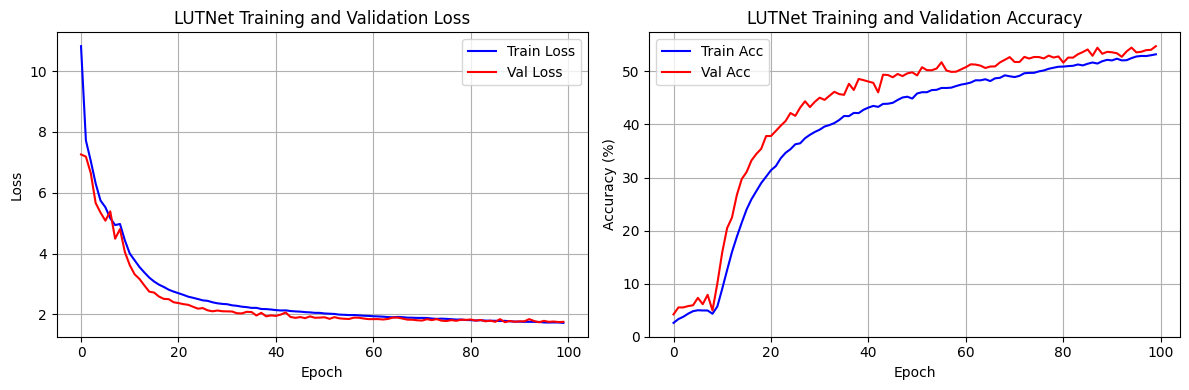

LUTNet Best validation accuracy: 54.75% at epoch 100


In [144]:
# Plot LUTNet training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(lut_train_losses, label='Train Loss', color='blue')
ax1.plot(lut_val_losses, label='Val Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('LUTNet Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(lut_train_accs, label='Train Acc', color='blue')
ax2.plot(lut_val_accs, label='Val Acc', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('LUTNet Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

if len(lut_val_accs) > 0:
    print(f"LUTNet Best validation accuracy: {max(lut_val_accs):.2f}% at epoch {lut_val_accs.index(max(lut_val_accs))+1}")


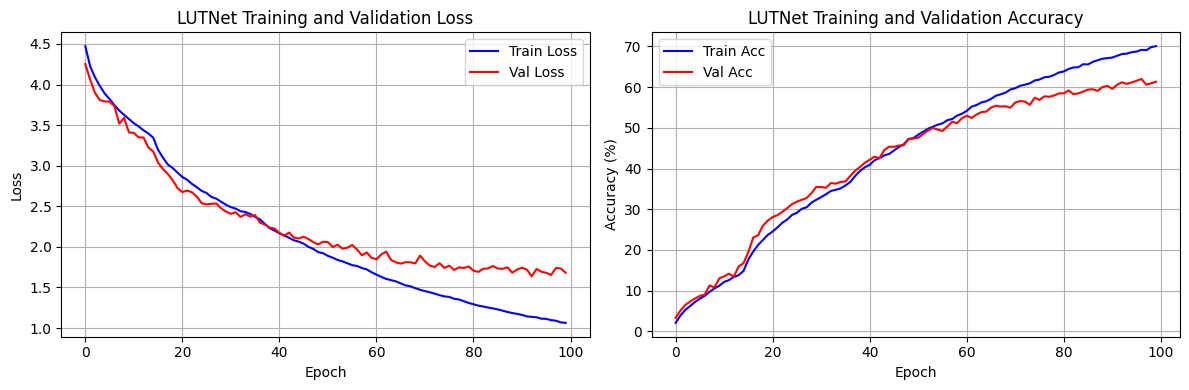

LUTNet Best validation accuracy: 62.01% at epoch 97


In [112]:
# Plot LUTNet training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(lut_train_losses, label='Train Loss', color='blue')
ax1.plot(lut_val_losses, label='Val Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('LUTNet Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(lut_train_accs, label='Train Acc', color='blue')
ax2.plot(lut_val_accs, label='Val Acc', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('LUTNet Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

if len(lut_val_accs) > 0:
    print(f"LUTNet Best validation accuracy: {max(lut_val_accs):.2f}% at epoch {lut_val_accs.index(max(lut_val_accs))+1}")


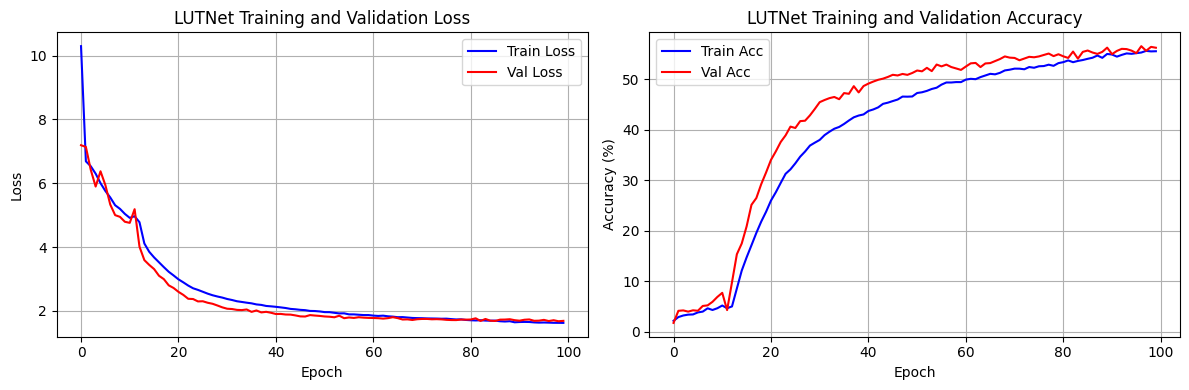

LUTNet Best validation accuracy: 56.53% at epoch 97


In [131]:
# Plot LUTNet training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(lut_train_losses, label='Train Loss', color='blue')
ax1.plot(lut_val_losses, label='Val Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('LUTNet Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(lut_train_accs, label='Train Acc', color='blue')
ax2.plot(lut_val_accs, label='Val Acc', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('LUTNet Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

if len(lut_val_accs) > 0:
    print(f"LUTNet Best validation accuracy: {max(lut_val_accs):.2f}% at epoch {lut_val_accs.index(max(lut_val_accs))+1}")


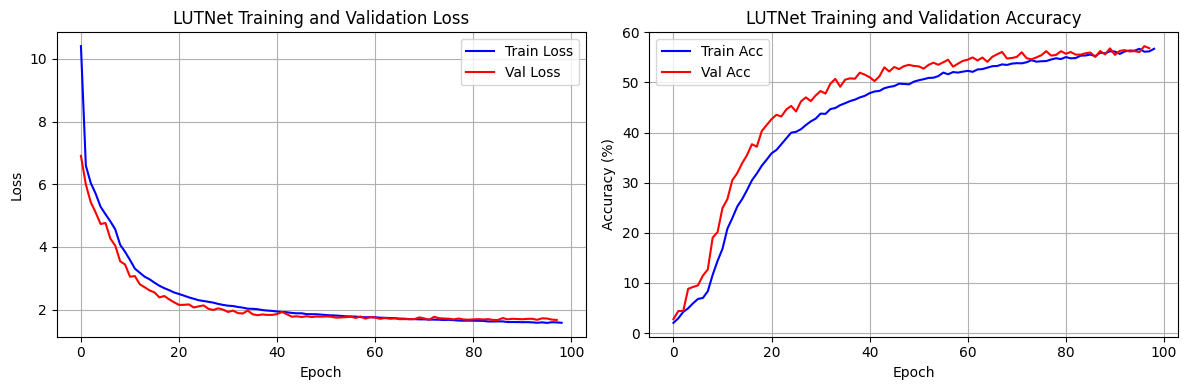

LUTNet Best validation accuracy: 57.24% at epoch 97


In [93]:
# Plot LUTNet training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(lut_train_losses, label='Train Loss', color='blue')
ax1.plot(lut_val_losses, label='Val Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('LUTNet Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(lut_train_accs, label='Train Acc', color='blue')
ax2.plot(lut_val_accs, label='Val Acc', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('LUTNet Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

if len(lut_val_accs) > 0:
    print(f"LUTNet Best validation accuracy: {max(lut_val_accs):.2f}% at epoch {lut_val_accs.index(max(lut_val_accs))+1}")


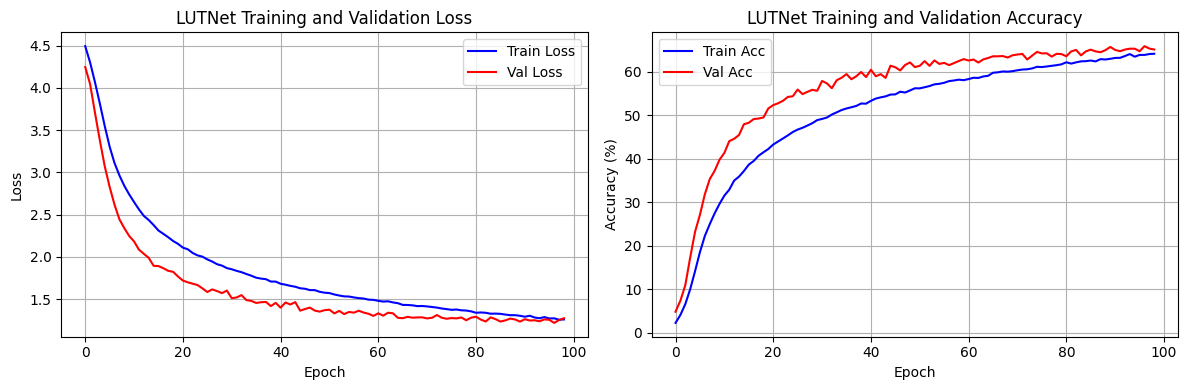

LUTNet Best validation accuracy: 65.85% at epoch 97


In [20]:
# Plot LUTNet training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
ax1.plot(lut_train_losses, label='Train Loss', color='blue')
ax1.plot(lut_val_losses, label='Val Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('LUTNet Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(lut_train_accs, label='Train Acc', color='blue')
ax2.plot(lut_val_accs, label='Val Acc', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('LUTNet Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

if len(lut_val_accs) > 0:
    print(f"LUTNet Best validation accuracy: {max(lut_val_accs):.2f}% at epoch {lut_val_accs.index(max(lut_val_accs))+1}")


In [158]:
t = torch.tensor([1232, 2])
t.size(0)

2